In [1]:
import os

config = {}
config["weights_file"] = os.getcwd() + '/model/weight'
config["patch_size"] = (64, 64, 64)  # switch to None to train on the whole image
config["patch_gap"] = 16
config["batch_size"] = 10
config["kfold"] = 5

config["input_shape"] = (1, None, None, None)
config["depth"] = 4 # depth of layers for V/Unet
config["n_base_filters"] = 32
config["pool_size"] = (2, 2, 2)  # pool size for the max pooling operations
config["deconvolution"] = True  # if False, will use upsampling instead of deconvolution

config["patience"] = 10  # learning rate will be reduced after this many epochs if the validation loss is not improving
config["early_stop"] = 10  # training will be stopped after this many epochs without the validation loss improving
config["initial_learning_rate"] = 0.00001
config["learning_rate_drop"] = 0.5  # factor by which the learning rate will be reduced
config["n_epochs"] = 1

In [2]:
from model.data import *
from model.model import *

d = Data()
d.load_data(config["patch_size"])

# prepare data for training
train_num, valid_num = d.prekfold(config["patch_size"], config["patch_gap"], config["batch_size"], config["kfold"])

Using TensorFlow backend.


In [3]:

model = unet_model_3d(input_shape=config["input_shape"],
                              pool_size=config["pool_size"],
                              initial_learning_rate=config["initial_learning_rate"],
                              deconvolution=config["deconvolution"],
                              depth=config["depth"],
                              n_base_filters=config["n_base_filters"])

# model.load_weights(os.getcwd() + '/model/weight/weights-01-0.02-0428-binary-patch.hdf5')

# 0,0.9986013862178413,0.00427185765564637,0.9978142036170056,0.017498897570287473
# model.load_weights(os.getcwd() + '/model/weight/fold-0-weights-04-0.34.hdf5')
# model.load_weights(os.getcwd() + '/model/weight/fold-all_patch_0-weights-06-0.42.hdf5')
model.load_weights(os.getcwd() + '/model/weight/fold0_all_patch_weights-02-0.34.hdf5') 
# model.load_weights(os.getcwd() + '/model/weight/fold-binary0-weights-06-0.02.hdf5')
# model.load_weights(os.getcwd() + '/model/weight/dice/weights-03-0.31.hdf5')
# model.load_weights(os.getcwd() + '/model/weight/binary/weights-01-0.02.hdf5')


In [4]:
# import copy

# class Reconstruct:
#     def __init__(self, ind, shape):
#         # find its original image: d.data[str(shape)][ind][0]
#         # find its target image: d.data[str(shape)][ind][1]
#         self.ind = ind
#         self.shape = shape
#         self.data = np.zeros(shape)
#         self.count = np.zeros(shape, dtype=np.int)
        
#     def add(self, patch, index):
#         # get patch data
#         patch_index = np.zeros(self.shape, dtype=np.bool)
#         patch_index[...,
#                     index[0]:index[0]+patch.shape[-3],
#                     index[1]:index[1]+patch.shape[-2],
#                     index[2]:index[2]+patch.shape[-1]] = True
#         patch_data = np.zeros(self.shape)
#         patch_data[patch_index] = patch.flatten()
        
#         # store patch data in self.data
#         new_data_index = np.logical_and(patch_index, np.logical_not(self.count > 0))
#         self.data[new_data_index] = patch_data[new_data_index]
        
#         # average overlapped region
#         averaged_data_index = np.logical_and(patch_index, self.count > 0)
#         if np.any(averaged_data_index):
#             self.data[averaged_data_index] = (self.data[averaged_data_index] * self.count[averaged_data_index] + 
#                                               patch_data[averaged_data_index]) / (self.count[averaged_data_index] + 1)
#         self.count[patch_index] += 1
        
    
# result = []
# fold_index = 0

# for i in d.valid_index:
#     j = d.valid_index[i][fold_index]
#     recons = Reconstruct(j, d.data[i][j][0].shape)
#     print(i)
#     for ind in range(d.patch_index[i][j].shape[0]):
#         index = d.patch_index[i][j][ind]
#         image_i = np.expand_dims(d.data[i][j][0][
#                          index[0]:index[0]+d.patch_size[0], 
#                          index[1]:index[1]+d.patch_size[1], 
#                          index[2]:index[2]+d.patch_size[2]], axis=0)
#         recons.add(model.predict([image_i[None, :]]), index)

#     result.append(copy.deepcopy(recons))

In [6]:
# d.show_image([merge_image[None, None, :], merge_target[None, None, :], merge_result[None, None, :]])

In [7]:

image = []
target = []
result = []
indices = []
shape = []
fold_index = 0
for i in d.valid_index:
    j = d.valid_index[i][fold_index]
    indices.append(d.patch_index[i][j])
    shape.append(d.data[i][j][0].shape)
    for ind in range(d.patch_index[i][j].shape[0]):
        patch = d.patch_index[i][j][ind]
        image_i = np.expand_dims(d.data[i][j][0][patch[0]:patch[0]+d.patch_size[0], 
                         patch[1]:patch[1]+d.patch_size[1], 
                         patch[2]:patch[2]+d.patch_size[2]], axis=0)
        target_i = np.expand_dims(d.data[i][j][1][patch[0]:patch[0]+d.patch_size[0], 
                         patch[1]:patch[1]+d.patch_size[1], 
                         patch[2]:patch[2]+d.patch_size[2]], axis=0)
        image.append(image_i)
        target.append(target_i)
        result.append(model.predict([image_i[None, :]]))
    break

In [8]:
# weight pixel based on distance to boundary 
# draw dice vs threashold => get best threashold
# calculate final dice after threashold



def reconstruct_from_patches(patches, patch_indices, data_shape, default_value=0):
    """
    Reconstructs an array of the original shape from the lists of patches and corresponding patch indices. Overlapping
    patches are averaged.
    :param patches: List of numpy array patches.
    :param patch_indices: List of indices that corresponds to the list of patches.
    :param data_shape: Shape of the array from which the patches were extracted.
    :param default_value: The default value of the resulting data. if the patch coverage is complete, this value will
    be overwritten.
    :return: numpy array containing the data reconstructed by the patches.
    """
    data = np.ones(data_shape) * default_value
    image_shape = data_shape[-3:]
    count = np.zeros(data_shape, dtype=np.int)
    for patch, index in zip(patches, patch_indices):
        image_patch_shape = patch.shape[-3:]
        patch_index = np.zeros(data_shape, dtype=np.bool)
        patch_index[...,
                    index[0]:index[0]+patch.shape[-3],
                    index[1]:index[1]+patch.shape[-2],
                    index[2]:index[2]+patch.shape[-1]] = True
        patch_data = np.zeros(data_shape)
        
        patch_data[patch_index] = patch.flatten()

        new_data_index = np.logical_and(patch_index, np.logical_not(count > 0))
        data[new_data_index] = patch_data[new_data_index]

        averaged_data_index = np.logical_and(patch_index, count > 0)
        if np.any(averaged_data_index):
            data[averaged_data_index] = (data[averaged_data_index] * count[averaged_data_index] + patch_data[averaged_data_index]) / (count[averaged_data_index] + 1)
        count[patch_index] += 1
    return data

In [9]:
merge_image = reconstruct_from_patches(image, indices[0], shape[0][-3:])
merge_target = reconstruct_from_patches(target, indices[0], shape[0][-3:])
merge_result = reconstruct_from_patches(result, indices[0], shape[0][-3:])


In [10]:
d.show_image([merge_image[None, None, :], merge_target[None, None, :], merge_result[None, None, :]])

interactive(children=(IntSlider(value=64, description='id', max=127), Output()), _dom_classes=('widget-interac…

In [14]:
print(K.eval(dice_coefficient(merge_target, merge_result)))

0.8631411575921044


In [33]:
def dice(y_true, y_pred, smooth=1.):
    y_true_f = np.array(y_true).flatten()
    y_pred_f = np.array(y_pred).flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    # tensorflow computation graph: will not configure print as one of the graph, unless using tf.Print()
    return (2.*intersection+smooth) / (np.sum(y_true_f)+np.sum(y_pred_f)+smooth)
# print(dice(merge_target, merge_result>0.02))

it = np.arange(0, 1.01, 0.01)
dice_thre = []
for i in it:
    dice_thre.append(dice(merge_target, merge_result>i))
#     i += gap


0.33 0.8813588255377262


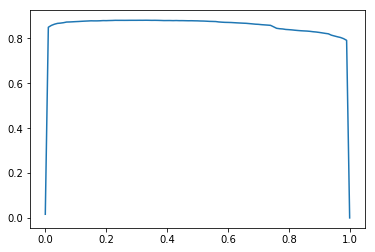

In [35]:
plt.plot(it, dice_thre)
print(it[np.argmax(dice_thre)], dice_thre[np.argmax(dice_thre)])

In [9]:
valid_generator = DataGenerator(d.data, d.patch_index, d.kfold, d.batch_size, 
                                d.patch_size, d.patch_gap, d.valid_index, False)
valid_generator.set_index(0)

In [10]:
dice_coeff = 0
num_iter = 0
for img, tar in valid_generator:
#     print(model.evaluate(img, tar, config["batch_size"], verbose=0)[1])
#     print(K.eval(dice_coefficient(tar, K.cast(model.predict(img, config["batch_size"]), 'float64'))))
#     break
    dice_coeff += K.eval(dice_coefficient(tar, K.cast(model.predict(img, config["batch_size"]),'float64')))
    num_iter += 1


KeyboardInterrupt: 

In [ ]:
dice_coeff /= num_iter
print(dice_coeff)

In [ ]:
print(num_iter, valid_num, valid_generator.__len__())

In [32]:
with h5py.File("./model/h5df_data/train_result_dice_0.84.h5", 'w') as f:
#     f.create_dataset("dice", data=dice_coeff)
    f.create_dataset("result", data=[merge_image[None, None, :], merge_target[None, None, :], merge_result[None, None, :]])